# Creating a Dataset
Import the required modules

In [1]:
import ipfshttpclient
import pytorchipfs
import torch
import torchvision.transforms as transforms

Pick some image hashes

N.B.: Many images are stored as webp, so you might need to install WEBP in order to read some images.

In [2]:
hashes = [
    'bafkreic3aeripksj7a7pnvkiybq3i43hme6pxlmpx7jaokubpz2lfdrvti',
    'bafybeic7qbuo2ail2y5urbm5btfp7dwcxigjs4kq6m36ecbozaurt4z3te',
    'bafkreidcct7qpk3tadwtqmboncnmfouu674vusm4zhvuxcmf2n57wxeqfa'
]

Initialize the dataset

In [3]:
client = ipfshttpclient.connect()

# Standard dataset
dataset = pytorchipfs.datasets.IPFSImageTensorDataset(
    client,
    'data', # Where the files will be downloaded
    None, # Don't make assumptions about the image shape
    hashes
)

# Dataset with cropping (to be fed to the model)
cropped_dataset = pytorchipfs.datasets.IPFSImageTensorDataset(
    client,
    'data', # Where the files will be downloaded
    None, # Don't make assumptions about the image shape
    hashes,
    transform=transforms.CenterCrop(32) # Crop the images
)

Visualize the results

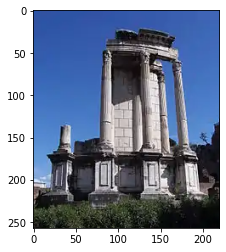

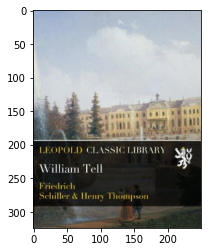

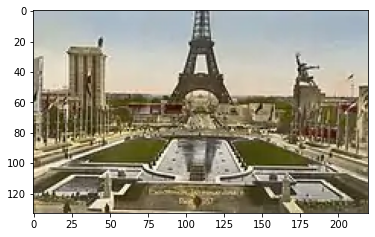

In [4]:
import matplotlib.pyplot as plt
import numpy as np

for image in dataset:
    # Convert to channel-last Numpy
    image = image.cpu().numpy() / 255
    image = np.transpose(image, (2, 1, 0))

    plt.imshow(image)
    plt.show()

# Backup with IPFS

Define a new model

In [5]:
import torch.nn as nn
model = nn.Sequential(
    nn.Conv2d(3, 16, 4, stride=2, padding=1),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(16*16*16, 10)
)
model.train()
model.cuda()

Sequential(
  (0): Conv2d(3, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
  (2): Flatten(start_dim=1, end_dim=-1)
  (3): Linear(in_features=4096, out_features=10, bias=True)
)

Add some simple training code

In [6]:
import torch.utils.data as data

batch_size = 1
dataloader = data.DataLoader(cropped_dataset, batch_size, shuffle=True)

def training_step(model, optimizer, loader):
    for images in dataloader:
        images = images.cuda()
        outputs = model(images)

        print('Outputs: ', outputs)

        # Toy loss
        loss = (outputs ** 2).sum()

        print('Loss: ', loss)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)

Create a CheckpointBackup

In [7]:
backup = pytorchipfs.checkpoint.CheckpointBackup(client, 'checkpoints')

Train for three iterarations and perform backups

In [8]:
for i in range(3):
    backup.store_checkpoint(model.state_dict())
    training_step(model, optimizer, dataloader)
    print()

print(backup.checkpoint_hashes)

Outputs:  tensor([[-31.6460,  41.7457, -79.9334, -74.0487, -76.6020, -19.8673, -54.0581,
         -23.9575,  88.4943,  34.5444]], device='cuda:0',
       grad_fn=<AddmmBackward>)
Loss:  tensor(33400.1250, device='cuda:0', grad_fn=<SumBackward0>)
Outputs:  tensor([[ 288656.2188, -381726.5625,  730352.8125,  676970.7500,  700270.7500,
          181921.8125,  493537.9688,  219633.0312, -808415.1250, -315333.9375]],
       device='cuda:0', grad_fn=<AddmmBackward>)
Loss:  tensor(2.7890e+12, device='cuda:0', grad_fn=<SumBackward0>)
Outputs:  tensor([[ -58.0951,   76.5706, -143.8133, -133.7103, -135.8831,  -36.2974,
          -96.7951,  -44.5693,  160.2001,   61.9186]], device='cuda:0',
       grad_fn=<AddmmBackward>)
Loss:  tensor(108434.2188, device='cuda:0', grad_fn=<SumBackward0>)

Outputs:  tensor([[ 14710.8389, -17117.0371,  35235.6172,  33081.6602,  33883.7969,
           9484.5410,  24018.6191,   9619.6797, -36528.3672, -15347.5977]],
       device='cuda:0', grad_fn=<AddmmBackward>)
L

Retrieve a checkpoint from IPFS

In [9]:
state_dict = backup.latest_checkpoint
model.load_state_dict(state_dict)

<All keys matched successfully>